In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.cuda.amp import autocast, GradScaler


In [2]:
df = pd.read_csv("/kaggle/input/d/jayjajoo01/house-b-csv/house_b_combined_dataset.csv")

In [3]:
weeks = [[(i*7)*86400 , (i*7+7)*86400 if len(df)>(i*7+7)*86400 else len(df) ] for i in range(int(30/7)+1)]
for index,week in enumerate(weeks):
    df.loc[week[0]:week[1],"Week"]= int(index)+1

In [4]:
for i in range(int(len(df)/86400)):
    df.loc[i*86400:(i*86400)+86400,"Day Of Week"] = (i%7)+1
df

,Unnamed: 0,contact_kitchen_cupboard_1,contact_kitchen_cupboard_2,contact_house_door,contact_wardrobe_door_1,contact_wardrobe_door_2,contact_shower_door,distance_tap,force_chair_1,force_chair_2,...,pressure_mat_bed_2,pressure_mat_armchair,sonar_bathroom_door,sonar_kitchen,sonar_closet,Resident1,Resident2,Hour,Week,Day Of Week
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,11,11,0,1.0,1.0
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,11,11,0,1.0,1.0
2,2,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,11,11,0,1.0,1.0
3,3,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,11,11,0,1.0,1.0
4,4,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,11,11,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2591995,86395,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,11,11,23,5.0,2.0
2591996,86396,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,11,11,23,5.0,2.0
2591997,86397,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,11,11,23,5.0,2.0
2591998,86398,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,11,11,23,5.0,2.0


In [5]:
# Assuming 'df' is the DataFrame that contains your data
# Preprocessing: Drop the Hour, Resident columns for simplicity
data = df.drop(columns=['Unnamed: 0']) # Remove non-sensor data
print(data.columns)
data = data.values 

Index(['contact_kitchen_cupboard_1', 'contact_kitchen_cupboard_2',
       'contact_house_door', 'contact_wardrobe_door_1',
       'contact_wardrobe_door_2', 'contact_shower_door', 'distance_tap',
       'force_chair_1', 'force_chair_2', 'force_chair_3', 'photocell_fridge',
       'photocell_kitchen_drawer', 'pressure_mat_couch_1',
       'pressure_mat_couch_2', 'pressure_mat_bed_1', 'pressure_mat_bed_2',
       'pressure_mat_armchair', 'sonar_bathroom_door', 'sonar_kitchen',
       'sonar_closet', 'Resident1', 'Resident2', 'Hour', 'Week',
       'Day Of Week'],
      dtype='object')


In [6]:
# Normalize or standardize data if needed
sc = StandardScaler()
data = sc.fit_transform(data)  # Normalize sensor data (optional)

In [7]:
from joblib import dump

dump(sc, "/kaggle/working/standardscaler_hb.joblib")

['/kaggle/working/standardscaler_hb.joblib']

In [8]:
# Convert data to tensor
data_tensor = torch.tensor(data, dtype=torch.float32)

In [9]:
# Create Dataset and DataLoader for batch processing
batch_size = 2**17  # Adjust based on GPU memory availability
dataset = TensorDataset(data_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [10]:
import torch
import torch.nn as nn

class LSTM_Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, seq_len):
        super(LSTM_Autoencoder, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, input_size)
        self.hidden_size = hidden_size
        self.seq_len = seq_len

    def forward(self, x):
        # Initialize hidden and cell states for encoder
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # batch_size, hidden_size
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # batch_size, hidden_size
        
        # Pass through encoder
        encoded, (hn, cn) = self.encoder(x, (h0, c0))
        
        # Pass through decoder
        decoded, _ = self.decoder(encoded, (hn, cn))
        
        # Map decoded output back to input size
        decoded = self.output_layer(decoded)
        
        return decoded


In [11]:
# Model Hyperparameters
input_size = data.shape[1]  # Number of sensor features
hidden_size = 256  # You can adjust this based on your model's complexity
seq_len = 1  # We are feeding one time step at a time (if you want multi-step sequence, change this)

In [12]:
# Initialize the model and move it to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM_Autoencoder(input_size=input_size, hidden_size=hidden_size, seq_len=seq_len).to(device)

In [13]:
model = nn.DataParallel(model)

model = model.to(device)

In [14]:
# Loss and Optimizer
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Initialize GradScaler for mixed precision training
scaler = GradScaler()

num_epochs = 100  # Adjust as needed
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (batch_data,) in enumerate(data_loader):
        batch_data = batch_data.to(device)
        batch_data = batch_data.unsqueeze(1)  # Ensure correct shape

        # Forward and backward pass under autocast for mixed precision
        with autocast():
            output = model(batch_data)
            loss = criterion(output, batch_data)
        
        # Scale loss to prevent underflow and backpropagate
        scaler.scale(loss).backward()
        
        # Optimizer step with scaled gradients
        scaler.step(optimizer)
        scaler.update()  # Update scaler for next iteration
        optimizer.zero_grad()  # Reset gradients
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(data_loader)
    if((epoch+1)%5==0):
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


/tmp/ipykernel_30/1740040032.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_30/1740040032.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch [5/100], Loss: 0.0915
Epoch [10/100], Loss: 0.0190
Epoch [15/100], Loss: 0.0078
Epoch [20/100], Loss: 0.0043
Epoch [25/100], Loss: 0.0029
Epoch [30/100], Loss: 0.0022
Epoch [35/100], Loss: 0.0018
Epoch [40/100], Loss: 0.0015
Epoch [45/100], Loss: 0.0013
Epoch [50/100], Loss: 0.0011
Epoch [55/100], Loss: 0.0009
Epoch [60/100], Loss: 0.0009
Epoch [65/100], Loss: 0.0007
Epoch [70/100], Loss: 0.0007
Epoch [75/100], Loss: 0.0006
Epoch [80/100], Loss: 0.0005
Epoch [85/100], Loss: 0.0004
Epoch [90/100], Loss: 0.0004
Epoch [95/100], Loss: 0.0003
Epoch [100/100], Loss: 0.0003


In [16]:
import numpy as np
from torch.cuda.amp import autocast

model.eval()
reconstruction_errors = []

with torch.no_grad():
    for batch_idx, (batch_data,) in enumerate(data_loader):
        batch_data = batch_data.to(device)
        batch_data = batch_data.unsqueeze(1)  

        with autocast():
            output = model(batch_data)

        error = torch.mean((batch_data - output) ** 2, dim=[1, 2]).cpu().numpy()
        reconstruction_errors.extend(error)

/tmp/ipykernel_30/2326915126.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


In [17]:
threshold = np.percentile(reconstruction_errors, 95)

anomalies = np.array(reconstruction_errors) > threshold

In [18]:
total_anomalies = (anomalies==True).sum()
total_anomalies

129516

In [19]:
(anomalies==False).sum()

2462484

In [20]:
df["Anomaly"] = anomalies

In [21]:
df.to_csv("/kaggle/working/house_b_detected_anomalies.csv")

In [22]:
len(df)

2592000

In [23]:
print(f"Percentage Anomalies = {(total_anomalies/len(df))*100}%")

Percentage Anomalies = 4.996759259259259%


In [24]:
torch.save(model.state_dict(), "/kaggle/working/lstm_autoencoder_hb.pth")
np.save("/kaggle/working/reconstruction_errors_hb.npy", reconstruction_errors)

<h1>Testing it on custom Data</h1>

In [25]:
import torch
# Remove "module." prefix if present
from collections import OrderedDict


class LSTM_Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, seq_len):
        super(LSTM_Autoencoder, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, input_size)
        self.hidden_size = hidden_size
        self.seq_len = seq_len

    def forward(self, x):
        # Initialize hidden and cell states for encoder
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        
        # Pass through encoder
        encoded, (hn, cn) = self.encoder(x, (h0, c0))
        
        # Pass through decoder
        decoded, _ = self.decoder(encoded, (hn, cn))
        
        # Map decoded output back to input size
        decoded = self.output_layer(decoded)
        
        return decoded

# Initialize the model (ensure the parameters match the saved model)
input_size = 25  # Adjust based on your data
hidden_size = 256  # Adjust based on your saved model
seq_len = 1      # Adjust based on your sequence length
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTM_Autoencoder(input_size=input_size, hidden_size=hidden_size, seq_len=seq_len).to(device)

In [26]:
# Load the saved state_dict
state_dict = torch.load("/kaggle/working/lstm_autoencoder_hb.pth", map_location=device)


new_state_dict = OrderedDict()
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # Remove 'module.' prefix
    new_state_dict[new_key] = v

# Load the updated state_dict into the model
model.load_state_dict(new_state_dict)

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully with adjusted keys!")



Model loaded successfully with adjusted keys!


/tmp/ipykernel_30/381041762.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/kaggle/working/lstm_autoencoder_hb.pth", map_location=device)


In [27]:
reconstruction_errors = np.load("/kaggle/working/reconstruction_errors_hb.npy")

threshold = np.percentile(reconstruction_errors, 95)
anomalies = reconstruction_errors > threshold

total_anomalies = anomalies.sum()
print(f"Total anomalies: {total_anomalies}")

Total anomalies: 129516


In [28]:
threshold

0.00014203230966813862

In [29]:
from joblib import load

# Load the scaler from the file
sc = load('/kaggle/working/standardscaler_hb.joblib')
sc

StandardScaler()

In [31]:
import numpy as np
import torch

# Replace with actual new data
new_data = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

# Transform new data using the StandardScaler
new_data = sc.transform(new_data)

# Convert to tensor and reshape for LSTM
new_data_tensor = torch.tensor(new_data, dtype=torch.float32).unsqueeze(0).to(device)  
# Shape: (batch_size=1, sequence_length=1, input_size=22)

# Forward pass through the model
model.eval()
with torch.no_grad():
    new_data_reconstructed = model(new_data_tensor)
    reconstruction_error = torch.mean((new_data_tensor - new_data_reconstructed) ** 2).item()

# Compare the error with the threshold
is_anomaly = reconstruction_error > threshold
print(f"Reconstruction Error: {reconstruction_error}, Anomaly: {is_anomaly}")


Reconstruction Error: 0.00034685671562328935, Anomaly: True


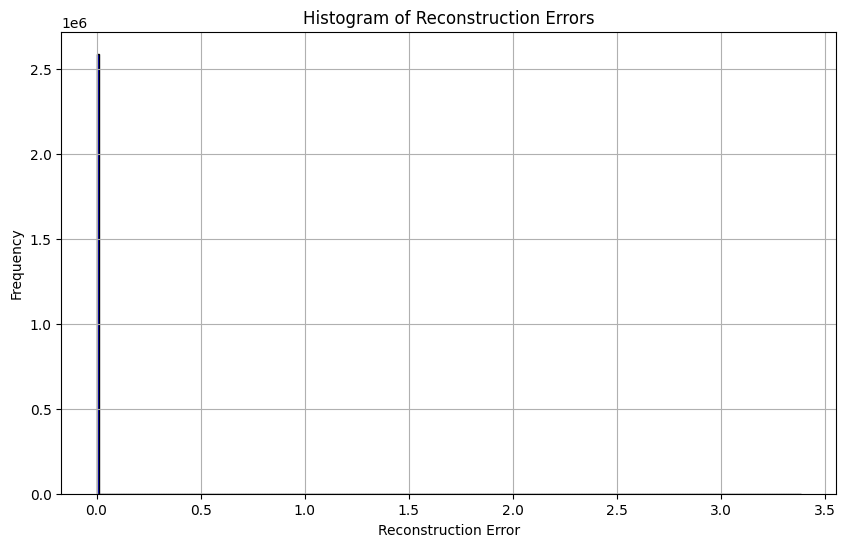

In [7]:
import matplotlib.pyplot as plt
import numpy as np

reconstruction_errors = np.load("../Pipeline/House A files/reconstruction_errors_ha.npy")

plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors,bins = 300 ,color='blue', edgecolor='black')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()